In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Dreamer"
JOB_ID = "9735345" #NOTE <-- change this for new runs

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        for seed_num in range(3):
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [2]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
yes_075 = [7, 8, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [3]:
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID))

100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


In [4]:
print(mean_std_per_setting)

{0: (1.0892114241917927, 0.030028590614057774), 1: (1.1026465892791748, 0.023165266100528728), 2: (0.862434188524882, 0.07480769245900883), 3: (1.0967365900675456, 0.025271097328434505), 4: (0.8497713605562845, 0.03253033130074799), 5: (0.9724744558334351, 0.04885053969078592), 6: (0.7077555060386658, 0.013861285352820156), 7: (0.9256129066149393, 0.1657814113600506), 8: (0.9227114121119181, 0.16412013889207822), 9: (0.9322060942649841, 0.1498641635605515), 10: (0.9056475361188253, 0.15726788784935097), 11: (0.8406356573104858, 0.08737219930952987), 12: (0.7894478440284729, 0.1325139477673968), 13: (0.719443142414093, 0.12734631339268945), 14: (1.0861856540044148, 0.26449899641192604), 15: (1.079075853029887, 0.26183360727867516), 16: (1.1469945510228474, 0.38205153394628805), 17: (1.0564074913660686, 0.25659159334478077), 18: (1.0556213855743408, 0.1834205391156541), 19: (0.9029712478319804, 0.20876471710278943), 20: (0.6245344877243042, 0.025482929207967887)}


In [5]:
test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [6]:
print(test_only_true_view_05)

[(1.0892114241917927, 0.030028590614057774), (1.1026465892791748, 0.023165266100528728), (1.0967365900675456, 0.025271097328434505), (0.9724744558334351, 0.04885053969078592)]


In [7]:
xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

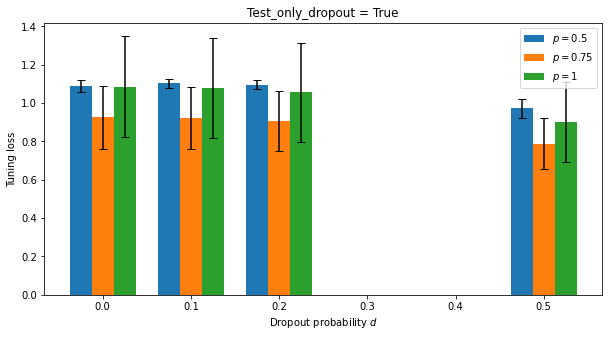

In [11]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = True")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()

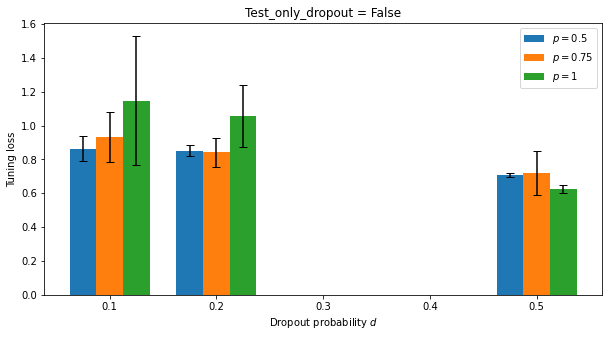

In [12]:
# eval for test_only false
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = False")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()